<a href="https://colab.research.google.com/github/andrewdk1123/KoSentiment/blob/main/Simple_RNN_for_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

In [1]:
# Load packages
import pandas as pd
import io

## Upload Train and Test Set

In [2]:
from google.colab import files

uploaded = files.upload()

Saving processed_training.csv to processed_training.csv


In [3]:
print(uploaded.keys())

dict_keys(['processed_training.csv'])


In [4]:
train_data = pd.read_csv(io.BytesIO(uploaded['processed_training.csv']), sep = ',')

cols_to_keep = ['label', 'sentence', 'tokenized_sentence', 'cleaned_tokens']
train_data = train_data.loc[:, cols_to_keep]
train_data.head()

,label,sentence,tokenized_sentence,cleaned_tokens
0,0,일은 왜 해도 해도 끝이 없을까? 화가 난다.,"['일은', '왜', '해도', '해도', '끝이', '없을까', '?', '화가'...","['일은', '왜', '해도', '해도', '끝이', '없을까', '화가', '난다']"
1,0,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,"['이번', '달에', '또', '급여', '##가', '깎', '##였어', '!...","['이번', '달에', '또', '급여', '깎', '물가', '오르는', '월급'..."
2,0,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,"['회사에', '신입', '##이', '들어왔', '##는데', '말투', '##가...","['회사에', '신입', '들어왔', '말투', '거슬', '그런', '애를', '..."
3,0,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,"['직장', '##에서', '막내', '##라는', '이유로', '나에게', '##...","['직장', '막내', '이유로', '나에게', '온갖', '심', '시켜', '일..."
4,0,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,"['얼마', '전', '입사', '##한', '신입', '##사원', '##이', ...","['얼마', '전', '입사', '신입', '나를', '무시', '것', '같아서'..."


In [5]:
uploaded = files.upload()

Saving processed_test.csv to processed_test.csv


In [6]:
print(uploaded.keys())

dict_keys(['processed_test.csv'])


In [7]:
test_data = pd.read_csv(io.BytesIO(uploaded['processed_test.csv']), sep = ',')

test_data = test_data.loc[:, cols_to_keep]
test_data.head()

,label,sentence,tokenized_sentence,cleaned_tokens
0,0,이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 우리 팀이 감점을 받았어. 너...,"['이번', '프로젝트', '##에서', '발표를', '하는데', '내가', '실수...","['이번', '프로젝트', '발표를', '하는데', '내가', '실수', '바람에'..."
1,0,회사에서 중요한 프로젝트를 혼자 하게 됐는데 솔직히 두렵고 무서워.,"['회사에서', '중요한', '프로젝트를', '혼자', '하게', '됐는데', '솔...","['회사에서', '중요한', '프로젝트를', '혼자', '하게', '됐는데', '솔..."
2,0,상사가 너무 무섭게 생겨서 친해지는 게 너무 두려워.,"['상', '##사가', '너무', '무섭게', '생겨서', '친', '##해지는'...","['상', '너무', '무섭게', '생겨서', '친', '게', '너무', '두려워']"
3,0,이번에 힘들게 들어간 첫 직장이거든. 첫 직장이라서 그런지 너무 긴장된다.,"['이번에', '힘들게', '들어간', '첫', '직장', '##이거', '##든'...","['이번에', '힘들게', '들어간', '첫', '직장', '첫', '직장', '그..."
4,0,직장에서 동료들이랑 관계가 안 좋아질까 봐 걱정돼.,"['직장', '##에서', '동료', '##들이랑', '관계가', '안', '좋아질...","['직장', '동료', '관계가', '안', '좋아질', '봐', '걱정']"


## Data Encoding

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Load and apply KoBERT tokenizer to sentence
tokenizer = BertTokenizer.from_pretrained('kykim/bert-kor-base')

In [9]:
# Build a vocabulary mapping
vocab = {word: idx + 1 for idx, (word, _) in enumerate(tokenizer.get_vocab().items())}

# Create reverse_vocab by swapping keys and values
reverse_vocab = {idx: word for word, idx in vocab.items()}

# Convert cleaned tokens to numerical indices
train_data['numerical_tokens'] = train_data['cleaned_tokens'].apply(lambda tokens: [vocab.get(token, 0) for token in tokens])

# Pad sequences using PyTorch
padded_sequences = pad_sequence([torch.tensor(tokens) for tokens in train_data['numerical_tokens']], batch_first=True, padding_value=0)

# Add the padded_sequences to the DataFrame
train_data['padded_sequences'] = [list(seq) for seq in padded_sequences]

# Display the DataFrame
print(train_data['padded_sequences'])

0        [tensor(2036), tensor(0), tensor(5930), tensor...
1        [tensor(2036), tensor(0), tensor(5922), tensor...
2        [tensor(2036), tensor(0), tensor(7852), tensor...
3        [tensor(2036), tensor(0), tensor(6268), tensor...
4        [tensor(2036), tensor(0), tensor(5599), tensor...
                               ...                        
57749    [tensor(2036), tensor(0), tensor(2431), tensor...
57750    [tensor(2036), tensor(0), tensor(2431), tensor...
57751    [tensor(2036), tensor(0), tensor(2431), tensor...
57752    [tensor(2036), tensor(0), tensor(2784), tensor...
57753    [tensor(2036), tensor(0), tensor(2431), tensor...
Name: padded_sequences, Length: 57754, dtype: object


In [10]:
len(vocab)

42000

In [11]:
print("Max Sequence Length:", max(len(tokens) for tokens in train_data['cleaned_tokens']))
print(len(train_data['padded_sequences'][0]) == max(len(tokens) for tokens in train_data['cleaned_tokens']))

print(train_data['padded_sequences'][0])

Max Sequence Length: 240
True
[tensor(2036), tensor(0), tensor(5930), tensor(5884), tensor(0), tensor(2015), tensor(0), tensor(0), tensor(5731), tensor(0), tensor(2015), tensor(0), tensor(0), tensor(7678), tensor(3239), tensor(0), tensor(2015), tensor(0), tensor(0), tensor(7678), tensor(3239), tensor(0), tensor(2015), tensor(0), tensor(0), tensor(2758), tensor(5922), tensor(0), tensor(2015), tensor(0), tensor(0), tensor(5608), tensor(5888), tensor(2495), tensor(0), tensor(2015), tensor(0), tensor(0), tensor(7822), tensor(2103), tensor(0), tensor(2015), tensor(0), tensor(0), tensor(2788), tensor(3111), tensor(0), tensor(2038), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), ten

In [12]:
test_data['numerical_tokens'] = test_data['cleaned_tokens'].apply(lambda tokens: [vocab.get(token, 0) for token in tokens])

# Pad sequences using PyTorch
padded_sequences_test = pad_sequence([torch.tensor(tokens) for tokens in test_data['numerical_tokens']], batch_first=True, padding_value=0)
test_data['padded_sequences'] = [list(seq) for seq in padded_sequences_test]

# Build and Train the Model

In [52]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, mask=None):
        embedded = self.embedding(x)
        # Apply the mask to the embedded sequence if provided
        if mask is not None:
            embedded = embedded * mask.unsqueeze(2)
        output, hidden = self.rnn(embedded)
        last_hidden_state = hidden[-1, :, :]
        return self.fc(last_hidden_state)

# Define hyperparameters
vocab_size = len(vocab) + 1  # Add 1 for padding token
embedding_dim = 50
hidden_dim = 128
output_dim = 1  # Assuming binary classification

# Instantiate the model
model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim)

# Print the model architecture
print(model)


SentimentRNN(
  (embedding): Embedding(42001, 50)
  (rnn): RNN(50, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [53]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust the learning rate as needed

In [54]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, train_data['label'].values, test_size=0.2, random_state=1123)

In [55]:
# Convert data to PyTorch tensors and create DataLoader
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

<ipython-input-55-3e8b59e4bdd0>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
<ipython-input-55-3e8b59e4bdd0>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val), torch.tensor(y_val))


Epoch 1/10, Training Loss: 0.547988772392273, Validation Loss: 0.512558606777402, Validation Accuracy: 0.7937840879577526
Epoch 2/10, Training Loss: 0.5509679317474365, Validation Loss: 0.5087360766052541, Validation Accuracy: 0.7937840879577526
Epoch 3/10, Training Loss: 0.4853702485561371, Validation Loss: 0.509606398436246, Validation Accuracy: 0.7937840879577526
Epoch 4/10, Training Loss: 0.45954519510269165, Validation Loss: 0.5087286530278664, Validation Accuracy: 0.7937840879577526
Epoch 5/10, Training Loss: 0.5068420767784119, Validation Loss: 0.5096466888709622, Validation Accuracy: 0.7937840879577526
Epoch 6/10, Training Loss: 0.5273862481117249, Validation Loss: 0.508868814337978, Validation Accuracy: 0.7937840879577526
Epoch 7/10, Training Loss: 0.5536660552024841, Validation Loss: 0.5092090961024247, Validation Accuracy: 0.7937840879577526
Epoch 8/10, Training Loss: 0.42239540815353394, Validation Loss: 0.49274951729985234, Validation Accuracy: 0.7937840879577526
Epoch 9/1

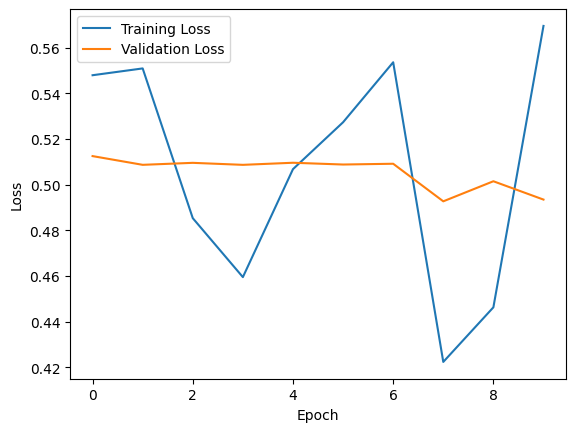

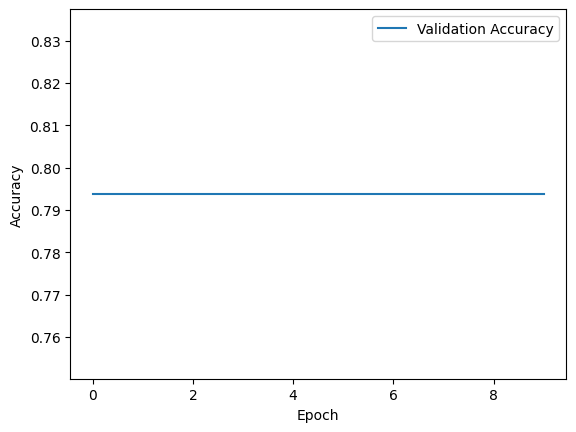

In [56]:
import matplotlib.pyplot as plt

num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y.to(torch.float))
        loss.backward()
        optimizer.step()

    # Calculate validation loss and accuracy
    model.eval()
    val_losses_batch = []
    val_preds_all = []
    val_targets_all = []

    with torch.no_grad():
        for batch_X_val, batch_y_val in val_loader:
            val_outputs = model(batch_X_val)
            val_loss = criterion(val_outputs.squeeze(), batch_y_val.to(torch.float))
            val_preds = torch.round(torch.sigmoid(val_outputs))

            val_losses_batch.append(val_loss.item())
            val_preds_all.append(val_preds)
            val_targets_all.append(batch_y_val)

    # Combine results from all batches
    val_loss = sum(val_losses_batch) / len(val_losses_batch)
    val_preds_all = torch.cat(val_preds_all)
    val_targets_all = torch.cat(val_targets_all)

    # Calculate validation accuracy
    val_accuracy = accuracy_score(val_targets_all.numpy(), val_preds_all.detach().numpy())

    # Store losses and accuracy for plotting
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print or log the training and validation metrics
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the validation accuracy
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [59]:
# Create DataLoader for test data
test_dataset = torch.utils.data.TensorDataset(torch.tensor(padded_sequences_test), torch.tensor(test_data['label'].values, dtype=torch.float))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()

# Make predictions on test data
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for test_batch_data, test_batch_labels in test_loader:
        test_batch_data = test_batch_data.to(torch.long)
        test_batch_labels = test_batch_labels.to(torch.float)

        test_outputs = model(test_batch_data)
        threshold = 0.1
        batch_predictions = (torch.sigmoid(test_outputs) > threshold).cpu().numpy().astype(int)
        test_predictions.extend(batch_predictions)
        test_true_labels.extend(test_batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_f1_score = f1_score(test_true_labels, test_predictions)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 Score: {test_f1_score}")


<ipython-input-59-044ae08dbb3f>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(torch.tensor(padded_sequences_test), torch.tensor(test_data['label'].values, dtype=torch.float))


Test Accuracy: 0.18268072289156626
Test F1 Score: 0.3089265248949446


# XAI Analysis with Captum

In [34]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00


In [60]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [61]:
# Convert the input sequence to a tensor and add batch dimension
input_data = torch.tensor(padded_sequences_test[0]).unsqueeze(0)

# Choose Attribution Method
embedding_layer = model.embedding

# Create an interpretation object
lig = LayerIntegratedGradients(model, embedding_layer)

# Prepare Baseline Data
# For sequences, a good baseline is often an empty sequence (all zeros)
baseline_data = torch.zeros_like(input_data)

<ipython-input-61-f021764600a9>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(padded_sequences_test[0]).unsqueeze(0)


In [62]:
input_data

tensor([[2036,    0, 5922, 4415,    0, 2015,    0,    0, 7602, 3829, 6044, 7329,
            0, 2015,    0,    0, 4354, 7533, 3967,    0, 2015,    0,    0, 7650,
         3053, 3202,    0, 2015,    0,    0, 2810, 2103,    0, 2015,    0,    0,
         5231, 5100,    0, 2015,    0,    0, 4346, 3695, 5618,    0, 2015,    0,
            0, 5776, 3995,    0, 2015,    0,    0, 7368, 5922,    0, 2015,    0,
            0, 2118,    0, 2015,    0,    0, 4353, 5525,    0, 2015,    0,    0,
         2853, 4216,    0, 2015,    0,    0, 4318, 5509, 7678,    0, 2038,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [63]:
# Check the output dimension of the model
output_dim = model.fc.out_features  # Assuming your linear layer is named fc
print(f"Model Output Dimension: {output_dim}")

Model Output Dimension: 1


In [75]:
valid_target_classes = [0, 1]
assert target_class in valid_target_classes, f"Invalid target_class. Expected one of {valid_target_classes}, but got {target_class}."

In [76]:
target_class

1

In [71]:
# Set the model to evaluation mode
model.eval()

# Create a mask where the value is 1 for non-padding tokens and 0 for padding tokens
mask = (input_data != 0).float()

In [78]:
embedding_layer = model.embedding

# Create an interpretation object
lig = LayerIntegratedGradients(model, embedding_layer)

# Prepare baseline data
baseline_data = torch.zeros_like(input_data)

# Compute Attributions with the mask
attributions, delta = lig.attribute(input_data, baseline_data, target=target_class, additional_forward_args=(mask,))

IndexError: ignored

In [66]:
# Step 6: Visualize Attributions
# Convert attributions to word importances for visualization
word_importances = [visualization.format_word_importances(attr) for attr in attributions]

# Visualize using Captum's text visualization
visualization.visualize_text(word_importances)

# Optionally, you can print the convergence delta
print(f"Convergence Delta: {delta.item()}")


TypeError: ignored